<a href="https://colab.research.google.com/github/SzymonNowakowski/Machine-Learning-2024/blob/master/Lab09_multi-layer-perceptron-MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 9 - Multi Layer Perceptron, MLP

### Author: Szymon Nowakowski

# Presentation on Tensors and Linear Layers
--------------------

We shall start off by going through a [short presentation on tensors and linear layers](https://github.com/SzymonNowakowski/Machine-Learning-2024/blob/master/tensors_and_linear_layers.pdf). It is best to first download it and then go through it in a slide-show layout.

# Multi Layer Perceptron (MLP) Diagram
------------------

![network diagram](https://raw.githubusercontent.com/SzymonNowakowski/Machine-Learning-2024/refs/heads/master/MLP_diagram.jpg)

# A Non-Linearity
---------------------

A nonlinear component in-between the linear layers is essential:

$$
l_{i+1} = f(W \cdot l_i),
$$
with $f$ being a sigmoid $f(\cdot)=\sigma(\cdot)$, hiperbolic tangent $f(\cdot)=\tanh(\cdot)$ or a Rectified Linear Unit (ReLU) $f(\cdot)=[\cdot]_+$ (taking the positive part).

The **sigmoid function** is defined as:

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

It maps any input $x$ to the range $(0,1)$, making it useful for probabilistic interpretations and smooth gradient updates. However, it can suffer from vanishing gradients for large positive or negative inputs.

The **hyperbolic tangent (tanh) function** is defined as:

$$
\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
$$

It maps any input $x$ to the range $(-1,1)$, making it **zero-centered**, which can help with optimization compared to the sigmoid function.

Alternatively, **tanh** can be expressed as a **scaled sigmoid**:

$$
\tanh(x) = 2\sigma(2x) - 1
$$

This shows that **tanh** is just a stretched and shifted version of **sigmoid**, allowing for stronger gradients in the middle range and reducing saturation effects compared to sigmoid.


As we said, a non-linear component is essential:
1. without it, a compostion of linear components would be just a linear component, so a multilayer network would be equivalent to a single layered network.
2. it is a nonlinear component that enables a neural network to express nonlinear functions, too.




# MINIST dataset
----------------------

In this workshop, we will construct an MLP network designed to a specific task of classification of MNIST dataset: a set of handwritten digits from *zero* to *nine*. MNIST stands for Modified National Institute of Standards and Technology database.

**You can read more about this dataset [here](https://colah.github.io/posts/2014-10-Visualizing-MNIST/#MNIST).**




# Multi Layer Perceptron Notation
---------------------------------

In this workshop we will be classifying 28 by 28 images into 10 classes. Thus, a four layer perceptron (our classificator) we will work further with can be defined as
$\hat f:\mathbb{R}^{28\cdot 28} \rightarrow \mathbb{R}^{10}$ defined as

$$\hat f \left(x; W_1, W_2, W_3, W_4, b_1, b_2, b_3, b_4 \right) =  W_4 \left[ W_3 \left[ W_2 \left[ W_1 x  + b_1 \right]_+  + b_2 \right]_+  + b_3 \right]_+ + b_4,$$

where matrices $W_1, \ldots, W_4$ are tensors of order two (matrices) with matching dimensions and bias terms $b_1, \ldots, b_4$ are tensors of order one (vectors) of matching dimensions, and we are using ReLU activation.

Note, that there is no nonlinear activation after the last layer in our neural network. **There is an implicit softmax applied while cross entropy loss is calculated by `torch.nn.functional`.**


# Reading MNIST Dataset to Play with It
--------------------

In [1]:
import torch
import torchvision
from matplotlib import pyplot

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=None)

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 472kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.37MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.66MB/s]


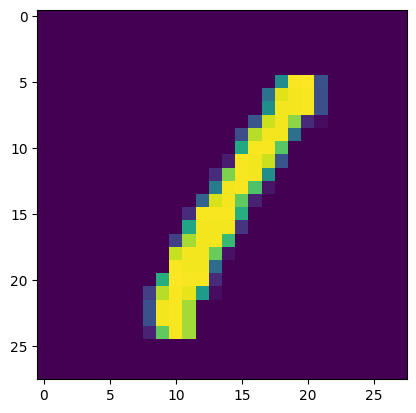

In [2]:
train_image, train_target = trainset[3]    #let us examine the 0-th sample
pyplot.imshow(train_image)
pyplot.show()

In [3]:
trainset.data[3]     #it will be shown in two rows, so a human has hard time classificating it

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0, 124, 253, 255,  63,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [4]:
trainset[3][1]    #check if you classified it correctly in your mind

1

# Rereading the MNIST Data (Serious Preparation for Training)
------------------

In [5]:
(trainset.data.numpy().mean()/255.0, trainset.data.numpy().std()/255.0)   #MNIST datapoints are RGB integers 0-255

(np.float64(0.1306604762738429), np.float64(0.30810780385646264))

In [6]:
transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

## Visualizing Data


### Labels (Ground Truth Outputs)

In [7]:
for i, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        if i<5:
            print(i, "-th batch labels :", batch_labels)

0 -th batch labels : tensor([4, 4, 8,  ..., 2, 9, 2])
1 -th batch labels : tensor([8, 1, 4,  ..., 5, 0, 2])
2 -th batch labels : tensor([8, 5, 5,  ..., 0, 3, 8])
3 -th batch labels : tensor([3, 7, 1,  ..., 6, 3, 3])
4 -th batch labels : tensor([1, 7, 3,  ..., 7, 2, 2])


A single label is an entity of order zero (a constant), but batched labels are of order one. The first (and only) index is a sample index within a batch.

### Inputs

In [8]:
for i, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        if i==0:
            print(i, "-th batch inputs :", batch_inputs)

0 -th batch inputs : tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
     

OK, so each data image was initially a two dimensional image when we first saw it, but now the batches have order 4. The first index is a sample index within a batch, but a second index is always 0. This index represents a Channel number inserted here by `ToTensor()` transformation, always 0. As this order is one-dimensional, we can get rid of it, later, in training, in `Flatten` layer or by using `squeeze()` on a tensor.

# MLP Definition
-----------------

Your job now is to take the (fully functional) definition of the MLP structure and get rid off the Sequential layer.


In [12]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = torch.nn.Sequential(   #Sequential is a structure which allows stacking layers one on another in such a way,
                                          #that output from a preceding layer serves as input to the next layer
            torch.nn.Flatten(),   #change the last three orders in data (with dimensions 1, 28 and 28 respectively) into one order of dimensions (1*28*28)
            torch.nn.Linear(1*28*28, 1024),  #which is used as INPUT to the first Linear layer
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 2048),   #IMPORTANT! Please observe, that the OUTPUT dimension of a preceding layer is always equal to the INPUT dimension of the next layer.
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 256),
            torch.nn.ReLU(),            #ReLU (or a Sigmoid if you want) is a nonlinear function which is used in-between layers
            torch.nn.Linear(256, 10),
        )
        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):
        x = self.mlp(x)
        x = self.dropout(x)
        return x

In [10]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        relu = torch.nn.ReLU()
        flatten = torch.nn.Flatten()
        linear1 = torch.nn.Linear(1*28*28, 1024),  #which is used as INPUT to the first Linear layer

        # TODO: add more layers

        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):

        x = self.flatten(x)

        # TODO: add more layers

        x = self.dropout(x)
        return x

# Training Loop
----------------------

In [13]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = MLP().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001.

net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(8):  #  an epoch is a training run through the whole data set

    loss = 0.0
    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)  #explicitly moving the data to the target device
        batch_labels = batch_labels.to(device)

        #batch_inputs.squeeze(1)     #alternatively if not for a Flatten layer, squeeze() could be used to remove the second order of the tensor, the Channel, which is one-dimensional (this index can be equal to 0 only)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the MLP object. Please note, that the last layer of the MLP is linear
                                            #and MLP doesn't apply
                                            #the nonlinear activation after the last layer
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.
                                ####You can experiment - comment this line and check, that the loss DOE

Working on cuda
epoch: 0 batch: 0 current batch loss: 2.3039941787719727
epoch: 0 batch: 1 current batch loss: 2.061629056930542
epoch: 0 batch: 2 current batch loss: 1.6315670013427734
epoch: 0 batch: 3 current batch loss: 1.1471794843673706
epoch: 0 batch: 4 current batch loss: 1.0338681936264038
epoch: 0 batch: 5 current batch loss: 1.074769139289856
epoch: 0 batch: 6 current batch loss: 1.2180488109588623
epoch: 0 batch: 7 current batch loss: 0.7887773513793945
epoch: 0 batch: 8 current batch loss: 0.6260071992874146
epoch: 0 batch: 9 current batch loss: 0.7976412773132324
epoch: 0 batch: 10 current batch loss: 0.591491162776947
epoch: 0 batch: 11 current batch loss: 0.5333219766616821
epoch: 0 batch: 12 current batch loss: 0.5452953577041626


KeyboardInterrupt: 

# Testing
----------------------

Correct the code below so it works.

In [ ]:
good = 0
wrong = 0

net.eval()              #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing evaluation
with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
    for batch, data in enumerate(testloader): #batches in test are of size 1
        datapoint, label = data

        prediction = net(datapoint)                  #prediction has values representing the "prevalence" of the corresponding class
        classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

# **Homework Assignment - *Do Androids Dream of Electric Sheep?***

-------------------------------------  

"Do Androids Dream of Electric Sheep?" – the famous title of Philip K. Dick’s novel – raises a fascinating question: if artificial intelligence could dream, what would it see?  

In this assignment, we explore a phenomenon known as **neural network dreams**, where instead of optimizing a neural network's weights, we **optimize the input itself** to achieve a desired classification outcome. Given a fully trained MNIST classification network, your goal is to manipulate its inputs so that it confidently predicts each digit from 0 to 9, starting from pure noise.  

## **Tasks Description**  

During this class we designed and trained a **MNIST classification neural network**, which takes a **batch of grayscale images** of size **$28 \times 28$** as input and outputs a probability distribution over the 10 digit classes (0–9). However, instead of using real MNIST images, you will **treat the input batch itself as a set of trainable parameters** and optimize it so that the network classifies each image as a specific digit.  

1. Your first task is to generate **a batch of 10 images**, where each image is
   classified as one of the digits **0, 1, 2, ..., 9**, starting from an initial batch of ten random Gaussian noise images.  

   Discuss the following question: do the generated images resemble real MNIST digits? Why or why not?  

2. Discuss, how you would approach a second task of
   generating an image that   
   bares similarity to two or more digits simultaneously. **Implement your idea to see the results.**

3. Third task: repeat the previous tasks with an additional L2 penalty on noise within the images. Experiment with adding `lambda_l2 * dreamed_input_batch.pow(2).mean()` loss term, with `lambda_l2` being the penalty cooefficient within an exponential progression, say from 0.001 to 10.0. Are the new digits recognized correctly? How does the penalty impact the digit quality? Explain.

### **Optimization Process for Task 1**  

1. Start with a **batch of 10 random Gaussian noise images** as the initial input and $(0, 1, 2, \ldots, 9)$ as the expected output batch of target digits.  
2. Define the objective: maximize the neural network's confidence for the corresponding target digit for each image in the batch.  
3. Use **gradient descent** to modify the pixels in each image, making the network classify each one as the assigned digit.  
4. Repeat until the network assigns suffieciently high confidence to each image’s target class.  

### **Implementation Details**  

- The neural network weights **must remain frozen** during optimization. You are modifying only the input images.  
- The loss function should be the **cross-entropy loss** between the predicted probabilities and the desired class labels (plus an optional weighted L2 penalty regularizing the images in task 3).


## **Points to Note**  

1. **Visualize** the optimization process: Save images of the generated inputs at different steps and plot the classification confidence evolution over iterations.  
3. **Document your findings** and explain the behavior you observe.  

## **Task & Deliverables**  

- A **Colab notebook** containing solutions for both tasks:
  - The full implementation.
  - Visualizations of the generated batch of images.
  - A written explanation of your observations.
- **Bonus:** If you create an **animation** showing the evolution of the input images during optimization, it will be considered a strong enhancement to your submission.
  - You can generate an animation programmatically (e.g., using Matplotlib or OpenCV).
  - Or, save image frames and use external tools to create a video.
  - Provide a **link** to any video files in the README.
- Upload your notebook and results to your **GitHub repository** for the course.
- In the **README**, include a **link** to the notebook.
- In the notebook, include **“Open in Colab”** badge so it can be launched directly.


